# LSA analysis on a small corpus of Dutch poems

For JADS education on NLP, October 2018 by Michael Janus



# 1. Import of used packages

In [53]:
import numpy as np
import pandas as pd

import re
import os

import nltk as nltk
import sklearn as sklearn

import seaborn as sns
import matplotlib.pyplot as plt

<HR>
# 2. Import data from rijmzoeker.nl

## Import the verses

In [54]:
import re

def remove_html(input):
    "very simple version"
    tagreg = re.compile(r'(<!--.*?-->|<[^>]*>)')
    no_html = tagreg.sub(' ', input)
    return no_html


df_verses = pd.DataFrame()
list_ = []

dir = './rijmdata/versebase'
for filename in os.listdir(dir):
    filepath = dir+'/'+filename
    
    print("importing verses from ",filepath )
    
    with open (filepath, "r") as myfile:
        data=myfile.readlines()
    
    # first two lines is header, then each line is a verse
    for i in range(2,len(data)):
        # first number (until first comma) is it's verse_id
        line = data[i]
        id, title, verse = line.split(',',2)     
        list_.append([id, title, remove_html(verse)])
        
df_verses = pd.DataFrame(list_, columns=['verse_id','title','verse'])
df_verses['verse_id'] = df_verses['verse_id'].astype('str')
#df_verses.set_index('verse_id', inplace=True)

importing verses from  ./rijmdata/versebase/verses27.cat
importing verses from  ./rijmdata/versebase/verses28.cat
importing verses from  ./rijmdata/versebase/verses29.cat
importing verses from  ./rijmdata/versebase/verses30.cat
importing verses from  ./rijmdata/versebase/verses31.cat
importing verses from  ./rijmdata/versebase/verses32.cat
importing verses from  ./rijmdata/versebase/verses33.cat
importing verses from  ./rijmdata/versebase/verses34.cat
importing verses from  ./rijmdata/versebase/verses35.cat
importing verses from  ./rijmdata/versebase/verses36.cat
importing verses from  ./rijmdata/versebase/verses37.cat


In [55]:
df_verses.head(10)

,verse_id,title,verse
0,001,te dik door snacken,"Sint zag jou laatst weer snacken, hij kneep z..."
1,002,Mooi Kado,"oh oh oh Wat een mooi kado allemachtig, is ec..."
2,011,Internet-cadeau te laat,"Helaas ging internet niet zo snel, maar krijge..."
3,012,Opknapbeurt,Soms kijk ik in de spiegel en wordt dan helema...
4,02,Hulp voor de kerstman,Sint vindt als sportieve vent de kerstman ech...
5,021,bloem en kus in de regen,Jou ogen stralen van geluk Jij geeft mij een p...
6,022,Toneel,Sinterklaas wilde naar een voorstelling kijken...
7,031,Opgegeten letter,"Een letter van chocola is wat je wou, maar Sin..."
8,032,Plaid,Je wilde iets om het wat warmer te krijgen en ...
9,041,televisie kijken,"Als je je huiswerk hebt weten te klaren, ga je..."



## Import the tags associated with the verses

In [56]:
df_tags = pd.DataFrame()
list_ = []

dir = './rijmdata/tagbase'
for filename in os.listdir(dir):
    filepath = dir+'/'+filename
    
    # check if not an empty tag file
    with open (filepath, "r") as myfile:
        data=myfile.readlines()
        if len(data)<=1:
            print("skipping ", filepath)
            continue
    
    print("importing ",filepath )    
    df = pd.read_csv(filepath, sep=',', skiprows=1, header=None, dtype=str)
    list_.append(df)
df_tags = pd.concat(list_)
df_tags.columns = ['tag','verse_id']
df_tags['tag'] = df_tags['tag'].astype('str') 

importing  ./rijmdata/tagbase/tags1.cat
importing  ./rijmdata/tagbase/tags10.cat
importing  ./rijmdata/tagbase/tags11.cat
importing  ./rijmdata/tagbase/tags12.cat
importing  ./rijmdata/tagbase/tags13.cat
importing  ./rijmdata/tagbase/tags14.cat
importing  ./rijmdata/tagbase/tags15.cat
importing  ./rijmdata/tagbase/tags16.cat
importing  ./rijmdata/tagbase/tags17.cat
importing  ./rijmdata/tagbase/tags18.cat
importing  ./rijmdata/tagbase/tags19.cat
importing  ./rijmdata/tagbase/tags2.cat
importing  ./rijmdata/tagbase/tags20.cat
importing  ./rijmdata/tagbase/tags21.cat
importing  ./rijmdata/tagbase/tags22.cat
importing  ./rijmdata/tagbase/tags23.cat
skipping  ./rijmdata/tagbase/tags24.cat
skipping  ./rijmdata/tagbase/tags25.cat
importing  ./rijmdata/tagbase/tags26.cat
skipping  ./rijmdata/tagbase/tags27.cat
skipping  ./rijmdata/tagbase/tags28.cat
skipping  ./rijmdata/tagbase/tags29.cat
importing  ./rijmdata/tagbase/tags3.cat
skipping  ./rijmdata/tagbase/tags30.cat
skipping  ./rijmdata/tagb

In [57]:
df_tags[df_tags['verse_id']=='002']

,tag,verse_id
8,Kado,002
6,machtig,002
43,mooi,002
84,prachtig,002
0,Cadeau,002


## Merge the verses with tags

### first, consolidate the tags (this was hard!)

In [58]:
df_tags_sorted = df_tags.sort_values('verse_id')
df_tags_sorted['tags'] = df_tags_sorted.groupby('verse_id').transform(lambda k: ','.join(k))
df_tags_condensed = df_tags_sorted[['verse_id','tags']].drop_duplicates()

# Check
df_tags_condensed[df_tags_condensed['verse_id']=='641']

,verse_id,tags
79,641,"voetbal,ajax,voetballen,Sinterklaas"


In [59]:
df_verses_tagged = pd.merge(df_verses, df_tags_condensed, how='left', on=['verse_id'])
df_verses_tagged

,verse_id,title,verse,tags
0,001,te dik door snacken,"Sint zag jou laatst weer snacken, hij kneep z...","gewicht,snacken,lekker,eten,bikini,zomer,dik,z..."
1,002,Mooi Kado,"oh oh oh Wat een mooi kado allemachtig, is ec...","Cadeau,prachtig,Kado,mooi,machtig"
2,011,Internet-cadeau te laat,"Helaas ging internet niet zo snel, maar krijge...","afbeelding,laat,hebbeding,internet,snel,cadeau..."
3,012,Opknapbeurt,Soms kijk ik in de spiegel en wordt dan helema...,"onverzorgd,stank,ongeschoren,opknapbeurt,lelij..."
4,02,Hulp voor de kerstman,Sint vindt als sportieve vent de kerstman ech...,NaN
5,021,bloem en kus in de regen,Jou ogen stralen van geluk Jij geeft mij een p...,"kus,geluk,verlegen,bloemen,bloemstuk,liefde,regen"
6,022,Toneel,Sinterklaas wilde naar een voorstelling kijken...,Toneel theater
7,031,Opgegeten letter,"Een letter van chocola is wat je wou, maar Sin...","letter,sinterklaas,chocola,chocolade,eten"
8,032,Plaid,Je wilde iets om het wat warmer te krijgen en ...,plaid
9,041,televisie kijken,"Als je je huiswerk hebt weten te klaren, ga je...","vierkant,tv,huiswerk,kijken,ogen,televisie"


In [60]:
df_verses_tagged = df_verses_tagged.replace(np.nan, '', regex=True)

** (getting and merging the data from origninal format into the combined dataframe was tough!) **

<hr>

# 3. Pre-processing

### Merge verse and title in one field to have more topic content

In [61]:
df_verses_tagged['verse2'] = df_verses_tagged['title'].astype(str) + ' ' + df_verses_tagged['verse'].astype(str)


In [62]:
df_verses_tagged['verse2'].head(3)

0    te dik door snacken Sint zag jou laatst weer s...
1    Mooi Kado oh oh oh  Wat een mooi kado allemach...
2    Internet-cadeau te laat Helaas ging internet n...
Name: verse2, dtype: object

## Hand-pick a number of verses with distinct topics

In [63]:
# Helper functionss:

def show_verse(verse_id, sameline=True):
    title = str(df_verses_tagged.loc[df_verses_tagged['verse_id']==verse_id]['title'].iloc[0])
    verse = str(df_verses_tagged.loc[df_verses_tagged['verse_id']==verse_id]['verse'].iloc[0])
    if sameline:
        print(title,": ", verse[:80], "...")
    else:
        print(title)
        print(verse)
        
def show_title(verse_id):
    title = str(df_verses_tagged.loc[df_verses_tagged['verse_id']==verse_id]['title'].iloc[0])
    print(title)

Love -> '811' <br/>
Money -> '24' <br/>
Sports -> '05' <br/>
School -> '081' <br/>
Cars -> '73' <br/>
Music -> '332' <br/>
Computers -> '112' <br/>
    

In [64]:
show_verse('811', False) # ABOUT LOVE:

Verliefd op dansleraar
Dansen doet zij(hij) erg graag, met heel haar hart en ziel. En ze ging het nog leuker vinden, toen ze(hij) op de dansleraar(es) viel.    (met dank aan M.J.) 



In [65]:
show_verse('24', False) # ABOUT MONEY:

Kredietcrisis
Sinds een paar weken kan jij fluiten naar jouw zo spaarzaam opgebrachte duiten want jij hebt dus zogezegd verkeerd bij Icesafe (of iets anders) geld belegd in plaats van een mooie hoge rente krijg je zowaar totaal geen centen  Het kan nog wel maanden duren voordat zij weer een afschrift sturen



In [66]:
show_verse('05', False) # ABOUT SPORTS:

sportfiguur
Heel actief ben jij sinds kort bezeten van een nieuwe sport Piet, als atletische figuur houdt ook wel van de sportcultuur  dankzij voortdurend goed bewegen heb jij nog steeds geen buik gekregen blijf doorgaan met dit tijdverdrijf dan hou je lang een lekker lijf



In [67]:
show_verse('081', False) # ABOUT SCHOOL:

Proefwerk
Je zou wel willen dat je alles al kende want huiswerk maken, vind je doffe ellende! Steeds maar met je hoofd in de boeken, je zou veel liever je vrienden opzoeken... Maar ja, je moet nog even verder zweten, anders kan je dat proefwerk wel vergeten!



In [68]:
show_verse('73', False) # ABOUT CARS:

hard rijden
Jij geeft heel wat geld cadeau aan het justicieel incassobureau jij spekt de vaderlandse kas met dat extra dotje gas  want die flitser op een paal registreert dat allemaal ligt er na een week of wat een blanco giro op de mat



In [69]:
show_verse('332', False) # ABOUT MUSIC:

muziekliefhebber
van pop tot klassiek jij houdt echt van muziek



In [70]:
show_verse('112', False) # ABOUT COMPUTERS/GAMES:

irritante gamer
altijd als wij gaan gamen  moet jij controller 1 claimen en als je dan wordt verslagen ga je meteen lopen klagen echt man, op virtueel gebied ben je gewoon een stuk verdriet!



<hr>
# 4. Vectorize with TF-IDF

In [71]:
# from https://stackoverflow.com/questions/8897593/similarity-between-two-text-documents
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer() 
tfidf = vectorizer.fit_transform(df_verses_tagged['verse2'])
# no need to normalize, since Vectorizer will return normalized tf-idf
pairwise_similarity = tfidf * tfidf.T

In [72]:
# check one of the diagognal elements
print(pairwise_similarity[0,0])

1.0000000000000002


In [73]:
# check how many items there with a similarity > 0.5 (but excluding the 1.0 on the diagonals)
a = pairwise_similarity.A
print(a[(a>0.5) & (a<0.99)])

[0.79739568 0.54888682 0.79739568 0.5081049  0.69569115 0.5081049
 0.54888682 0.69569115]


### Only very few items have a considerable similarity

Plot the matrix as a heatmap to make it more visual, supressing the diagonal

In [74]:
print(pairwise_similarity.shape)

(231, 231)


In [75]:
pairwise_similarity_nodiag = pairwise_similarity - np.identity(231)
a = pairwise_similarity_nodiag.A

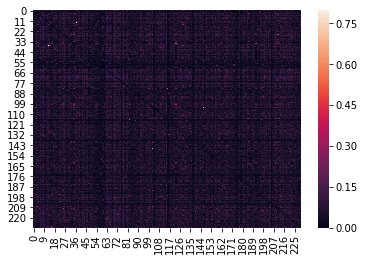

In [76]:
sns.heatmap(a)
plt.show()

Not much to see in this heatmap

### Let's check what the titles of the verses are that are closest to a few selected verses

In [77]:
row = df_verses_tagged.loc[df_verses_tagged['verse_id']=='811']
row

,verse_id,title,verse,tags,verse2
188,811,Verliefd op dansleraar,"Dansen doet zij(hij) erg graag, met heel haar ...","dansleraar,dans,danslerares,dansen,liefde,verl...",Verliefd op dansleraar Dansen doet zij(hij) er...


In [78]:
# get its pairwise similarities
similarities = pairwise_similarity[:,188]

# check if this the right column: row 188 should have value ~ 1
print(similarities[188])

  (0, 0)	0.9999999999999996


In [79]:
# check how many have a similarity bigger than 0.5
print((similarities.A > 0.5).sum())

1


In [80]:
# so, none except itself. There only a few items int the entire array between 0.5 and 0.99
a = pairwise_similarity.A
print(a[(a>0.5) & (a<0.99)])

[0.79739568 0.54888682 0.79739568 0.5081049  0.69569115 0.5081049
 0.54888682 0.69569115]


In [81]:
# let's find which these are
np.argwhere((a > 0.5) & (a<0.99))

array([[ 13,  37],
       [ 35, 123],
       [ 37,  13],
       [ 83, 116],
       [103, 147],
       [116,  83],
       [123,  35],
       [147, 103]], dtype=int64)

In [82]:
# let's check some of them (13 and 37)
def show_two_verses(index1, index2):
    print(df_verses_tagged.iloc[index1]['verse2'][:80], '...')
    print(df_verses_tagged.iloc[index2]['verse2'][:80], '...' )    
 
show_two_verses(13, 37)

gemeen Teletubbies lied Zie de maan schijnt door de tralies... Tinkiewinkie in d ...
Gemene Sint parodie Zie de maan schijnt door de tralies... zwarte piet is illega ...


In [83]:
# makes sense, it's almost exactly the same (with small variation)
# Lets's try the other ones

In [84]:
show_two_verses(35, 123)

Ik ben ook maar gewoon een mens Ik ben arm Ik ben niet rijk Ik heb het niet warm ...
Ik ik ben ik.  niemand kan mij veranderen.  zo ben ik.  en niet zoals die andere ...


In [85]:
show_two_verses(83, 116)

samen wij twee samen twee lichamen jij en ik ik je chick jij mijn held ik smelt  ...
Samen Samen op vakantie, samen naar de stad, samen aan de wandel, samen in het b ...


In [86]:
show_two_verses(103, 147)

Miljoenendroom Oh, had ik maar een paar miljoen, Dan hoefte ik nooit meer wat te ...
miljonair o had ik maar een paar miljoen dan zou ik lekker niets meer doen dagen ...


### The direct similarity is pretty good, but very strict so only very similar ones are close.

Let's loosen the score and look at the top N for just a few

# 5. Similarity of TF-IDF Vectors of selected poems

** get the top 10 (well 11, but one is itself) of the following verses: **

Love -> '811' <br/>
Money -> '24' <br/>
Sports -> '05' <br/>
School -> '081' <br/>
Cars -> '73' <br/>
Music -> '332' <br/>
Computers -> '112' <br/>

In [87]:
# trick to get top N from a numpy matrix
a[188].argsort()[-11:][::-1]

array([188, 165,  72,   0, 181,  96, 178,  12,  78, 127,  81], dtype=int64)

In [88]:
# put in a function

a = pairwise_similarity.A 

def show_sim_verses(verse_id, top_n = 10):
    verse_index = df_verses_tagged.index[df_verses_tagged['verse_id']==verse_id][0]
    list_of_indices = a[verse_index].argsort()[-top_n:][::-1]
    similarities = a[verse_index]
    for idx in list_of_indices:
        score = similarities[idx]
        print("{:.2f}".format(score),":", df_verses_tagged.iloc[idx]['verse2'][:80], '...')

In [89]:
show_sim_verses('811')  # LOVE

1.00 : Verliefd op dansleraar Dansen doet zij(hij) erg graag, met heel haar hart en zie ...
0.23 : Seksuele geaardheid Sommige mensen vinden haar(hem) raar, maar zo raar is zij(hi ...
0.21 : dansen voor publiek Zijn(haar) voeten gaan op en neer, bewegen heen en weer. Op  ...
0.17 : te dik door snacken Sint zag jou laatst weer snacken,  hij kneep zijn ogen dicht ...
0.17 : Held op sokken Als cadeau niet beister origineel maar je gebruikt ze toch wel ve ...
0.15 : Turn to the beat Zij draait rondjes om haar as, op de trilling van de bas. En op ...
0.13 : chaotisch Is het niet een tasje,  dan wel haar telefoon een gaatje in haar jasje ...
0.13 : alternatief beginnetje sint liep te denken wat hij jou zou ...uhm... geven?! hij ...
0.12 : Lieneke ,Kaarsen heb je altijd op je lijstje staan, Dus daar zal de Sint achtera ...
0.12 : Verliefd Piet Een van de Pietjes heeft een oogje op jou En schrijft de hele dag  ...


In [90]:
show_sim_verses('24')  # MONEY

1.00 : Kredietcrisis Sinds een paar weken kan jij fluiten naar jouw zo spaarzaam opgebr ...
0.18 : Fortis aandelen Jammer dat jouw geld nu vort is door dat gedoe met aandeel Forti ...
0.14 : Echte bloemen gaan dood Jouw planten sterven een voor een zo\'n liefhebber als j ...
0.13 : Turn-wijf turnen doe jij met veel plezier en bent daardoor een lenig dier benen  ...
0.12 : Roeispieren De Sint dacht dat jij helemaal ontspoorde, toen hij over jouw ambiti ...
0.12 : vroeg naar bed Jij maakt het zelden erg laat. Voordat het klokje elven slaat vin ...
0.11 : Strijkende moeder Als er iets is wat je niet graag doet, dan is het wel strijken ...
0.11 : Lieneke ,Kaarsen heb je altijd op je lijstje staan, Dus daar zal de Sint achtera ...
0.11 : Glaasje wijn Net als Sint en zijn Pieterbaasje houdt jij echt wel van een glaasj ...
0.11 : Verhuizen Je woont sinds kort op een nieuwe lokatie, maar een verhuizing is een  ...


In [91]:
show_sim_verses('05')  # SPORTS

1.00 : sportfiguur Heel actief ben jij sinds kort bezeten van een nieuwe sport Piet, al ...
0.17 : Ik hou van jou ik hou van een bloem ik hou van jou van een bloem heel even van j ...
0.16 : nieuwe tv Wat had jij toch weer geluk de oude die ging zomaar stuk. Geen beeld m ...
0.15 : Lieneke ,Kaarsen heb je altijd op je lijstje staan, Dus daar zal de Sint achtera ...
0.14 : Tennisballen Ook al is tennis jouw favoriete sport, op de baan schiet je wel een ...
0.13 : Verhuizen Je woont sinds kort op een nieuwe lokatie, maar een verhuizing is een  ...
0.12 : Glaasje wijn Net als Sint en zijn Pieterbaasje houdt jij echt wel van een glaasj ...
0.12 : Nieuwe golfclub In de golfshop dacht Sint “hup” ik geef die man een nieuwe club  ...
0.12 : bodylotion Na de douche, nog uit de kleren kan je nu dus lekker smeren want om l ...
0.12 : Sint`s Wondermiddel In dit verhaal, geheel op rijm vertel ik jou mijn groot gehe ...


In [92]:
show_sim_verses('081')  # SCHOOL

1.00 : Proefwerk Je zou wel willen dat je alles al kende want huiswerk maken, vind je d ...
0.20 : Ziektekostenpremie Je moet nog in dit oude jaar beslissen bij  jouw verzekeraar  ...
0.20 : Verhuizen Je woont sinds kort op een nieuwe lokatie, maar een verhuizing is een  ...
0.18 : Meisje gevonden In je schaarse vrije tijd is er iets dat je verblijd: een lief m ...
0.18 : Groep 2 gedichtje Je bent veel bezig met leren Zo reken je met appels en peren J ...
0.17 : televisie kijken Als je je huiswerk hebt weten te klaren, ga je nog even naar de ...
0.17 : geen enkele wens Ben je de vijftig gepasseerd hebt alles wat je hart begeert sta ...
0.17 : lekker kontje Je bent zeer zeker geen dom blondje je hebt echt wel een lekker ko ...
0.16 : huiswerk huiswerk lijkt soms wel een straf en het is nooit helemaal af het gaat  ...
0.16 : VERSTROOID Ookal ben je nog geen tachtig je bent best wel vergeetachtig! daardoo ...


In [93]:
show_sim_verses('73')  # CARS

1.00 : hard rijden Jij geeft heel wat geld cadeau aan het justicieel incassobureau jij  ...
0.14 : Celibaat...not! Soms heeft de Sint stil verdriet want een familie heeft hij niet ...
0.14 : Cadeau voor de hond In het grote boek van de Sint, Staat wat Sint van dieren vin ...
0.13 : Fazant Ojee wat is er nou aan de hand? Kijk eens aan, het is een fazant! Met all ...
0.13 : treinvertaging o, o, o wat is dat fijn lekker reizen met de trein maar met al di ...
0.13 : zwanger Sint en Piet hebben vernomen dat er een babytje gaat komen het groeien v ...
0.12 : Geen files op het dak eigenlijk ben je maar een stumper want elke ochtend sta ji ...
0.12 : Turnen de Sint staat echt enorm versteld van de kunsten die jij tentoon stelt in ...
0.11 : Lieneke ,Kaarsen heb je altijd op je lijstje staan, Dus daar zal de Sint achtera ...
0.11 : CD Crescendo, Tempo, Pianissimo, Bravo! Sinterklaas snapt er niets van, maar vin ...


In [94]:
show_sim_verses('332')  # MUSIC

1.00 : muziekliefhebber van pop tot klassiek jij houdt echt van muziek
 ...
0.12 : dansen voor publiek Zijn(haar) voeten gaan op en neer, bewegen heen en weer. Op  ...
0.12 : Glaasje wijn Net als Sint en zijn Pieterbaasje houdt jij echt wel van een glaasj ...
0.11 : Ik hou van jou ik hou van een bloem ik hou van jou van een bloem heel even van j ...
0.11 : Wat brengt de Sint? Sinterklaas is weer aangekomen. Wat heeft hij voor jou meege ...
0.10 : Concours hippique Jij weet het hippische gebeuren weer bijzonder in te kleuren r ...
0.10 : December Het is weer december, pakjestijd. De tijd van snoep en vooral gezelligh ...
0.10 : sportfiguur Heel actief ben jij sinds kort bezeten van een nieuwe sport Piet, al ...
0.10 : Echte bloemen gaan dood Jouw planten sterven een voor een zo\'n liefhebber als j ...
0.09 : Kaasplankje Sinterklaas houdt uiteraard vooral van speculaas maar jij bent meer  ...


In [95]:
show_sim_verses('112')  # COMPUTERS

1.00 : irritante gamer altijd als wij gaan gamen  moet jij controller 1 claimen en als  ...
0.18 : televisie kijken Als je je huiswerk hebt weten te klaren, ga je nog even naar de ...
0.18 : Aftershave Als je het gazon gemaaid hebt en het gras groeit niet zo goed is het  ...
0.15 : Storm Als de wind weer is gaan liggen, \'t land bekomen van de schrik, zijn wij  ...
0.14 : Vriend Ik wil graag even wat kwijt: Wij zijn vrienden voor altijd! Jij zult er a ...
0.14 : Ik hou van je en ga je daten ik smelt al weg als ik met je praat Ik geloofde het ...
0.13 : lelijk als de nacht meisje, je bent zo lelijk als de nacht. je bent toch niet zo ...
0.13 : Twitterende Zitzak Bewegingsloos lig je op de twee-zitter, een beetje app-en, Fa ...
0.12 : Geen files op het dak eigenlijk ben je maar een stumper want elke ochtend sta ji ...
0.11 : Lieneke ,Kaarsen heb je altijd op je lijstje staan, Dus daar zal de Sint achtera ...


### Only in a few cases the first matches are ok, but scores are really low

## Conclusions: only in a very few cases the direct similarity score returned a close match, but with very low score.  In most cases, no usable results are obtained.



<hr>

# 6. Generate LSA / Word-2-Vec Models

In [96]:
import sklearn
# Import all of the scikit learn stuff
from __future__ import print_function
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
import pandas as pd
import warnings
# Suppress warnings from pandas library
warnings.filterwarnings("ignore", category=DeprecationWarning,module="pandas", lineno=570)

## Create LSA model for the verses

In [97]:
docs = df_verses_tagged['verse2']
vectorizer = TfidfVectorizer()
dtm = vectorizer.fit_transform(docs)

In [98]:
# explore it a bit
pd.DataFrame(dtm.toarray(),index=docs,columns=vectorizer.get_feature_names()).head(2)

,12,18,480,50,aafke,aai,aaien,aan,aandeel,aandelen,...,zweet,zwembad,zwembroek,zwemmen,zweten,zwijgen,zwijn,écht,één,óók
verse2,,,,,,,,,,,,,,,,,,,,,
"te dik door snacken Sint zag jou laatst weer snacken, hij kneep zijn ogen dicht hij dacht: het is wel lekker maar slecht voor haar (zijn) gewicht als zij (hij) met zoveel eten nog lang zo door blijft gaan dan kan zij (hij) deze zomer niet haar bikini (zijn zwembroek)aan. (met dank aan Mieke) \n",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.096593,0.0,0.0,...,0.0,0.0,0.175961,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Mooi Kado oh oh oh Wat een mooi kado allemachtig, is echt prachtig! (met dank aan Ivy) \n",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.070736,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
# Get words that correspond to each column
vectorizer.get_feature_names()[:10]

['12',
 '18',
 '480',
 '50',
 'aafke',
 'aai',
 'aaien',
 'aan',
 'aandeel',
 'aandelen']

In [100]:
# Now fit LSA on the vectorized corpus. Use algorithm = “randomized” for large datasets
lsa = TruncatedSVD(10, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(dtm.asfptype())
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

In [101]:
pd.DataFrame(lsa.components_,columns = vectorizer.get_feature_names())

,12,18,480,50,aafke,aai,aaien,aan,aandeel,aandelen,...,zweet,zwembad,zwembroek,zwemmen,zweten,zwijgen,zwijn,écht,één,óók
0,0.003194,0.003513,0.003396,0.002938,0.003593,0.003847,0.003176,0.149043,0.003207,0.003207,...,0.002181,0.001866,0.002999,0.002424,0.003397,0.008252,0.003253,0.003339,0.004184,0.003125
1,0.010170,-0.001379,0.010577,-0.001370,0.000266,-0.003816,-0.003179,0.042167,-0.002534,-0.002534,...,-0.001690,-0.000217,-0.002319,0.000628,-0.003275,-0.008977,-0.004535,-0.004091,-0.004647,0.002155
2,0.002410,-0.001635,-0.000328,-0.003477,-0.013487,-0.004972,-0.006634,-0.082476,0.005030,0.005030,...,0.001945,0.000840,-0.015345,0.001091,0.020593,-0.003906,-0.001627,-0.007493,-0.002491,-0.005304
3,-0.001754,0.005253,-0.003669,0.001705,-0.011365,-0.026759,-0.001359,0.018255,0.001991,0.001991,...,-0.002332,-0.000131,-0.001240,-0.001822,0.002752,-0.012233,-0.002688,-0.002395,-0.008931,-0.012601
4,0.001518,-0.005564,-0.007772,0.010023,0.001025,-0.004034,0.007923,-0.018479,0.003597,0.003597,...,-0.009930,0.000698,0.000735,-0.002863,0.008246,0.000914,0.000981,-0.003586,-0.015732,-0.001636
5,-0.003704,0.000562,-0.013017,-0.002274,-0.012955,-0.013078,0.003320,0.011297,-0.002980,-0.002980,...,-0.006049,0.003077,0.009405,0.003447,-0.015876,-0.022530,0.020265,-0.003247,0.005542,-0.006506
6,-0.001866,-0.005387,0.002267,0.001048,0.002725,-0.008068,0.006434,0.093644,0.003945,0.003945,...,-0.007863,0.007884,-0.011422,0.005274,0.008133,-0.028412,-0.008631,-0.005283,-0.000786,-0.000237
7,-0.000234,-0.006300,0.009288,-0.009428,0.015251,-0.008536,-0.005189,-0.076301,0.000991,0.000991,...,-0.003558,-0.005997,-0.004286,-0.000777,0.000863,0.006051,0.019229,-0.000426,-0.002150,-0.005355
8,0.005384,-0.005836,-0.002293,-0.014047,0.015536,-0.009614,-0.009678,0.178138,-0.012775,-0.012775,...,-0.007915,-0.001839,0.028664,-0.010279,0.007710,0.017019,-0.010333,-0.007425,-0.011985,-0.005597
9,0.001402,-0.000298,0.003592,-0.000297,-0.000536,-0.002749,0.002424,-0.197192,0.002415,0.002415,...,0.013107,0.001208,0.007473,0.007208,0.005204,-0.004141,-0.003277,0.001314,0.016792,0.011127


In [102]:
pd.DataFrame(dtm_lsa, index = docs).head(3)

,0,1,2,3,4,5,6,7,8,9
verse2,,,,,,,,,,
"te dik door snacken Sint zag jou laatst weer snacken, hij kneep zijn ogen dicht hij dacht: het is wel lekker maar slecht voor haar (zijn) gewicht als zij (hij) met zoveel eten nog lang zo door blijft gaan dan kan zij (hij) deze zomer niet haar bikini (zijn zwembroek)aan. (met dank aan Mieke) \n",0.484451,-0.100529,-0.480580,-0.030815,0.017271,0.216130,-0.252366,-0.093826,0.617304,0.150760
"Mooi Kado oh oh oh Wat een mooi kado allemachtig, is echt prachtig! (met dank aan Ivy) \n",0.394475,0.130868,-0.214244,0.010753,0.735153,-0.002441,-0.024013,-0.321647,-0.145454,-0.340001
"Internet-cadeau te laat Helaas ging internet niet zo snel, maar krijgen doe je hem nog wel. Geniet maar vast van deze afbeelding, want het is echt een hebbeding. (met dank aan Winnie) \n",0.806661,-0.177559,0.120875,-0.420331,0.109626,0.060452,-0.183107,-0.173404,0.172568,-0.132032


## Create LSA model for the tags

In [103]:
# do same for tags:
tags = df_verses_tagged['tags']
vectorizer3 = TfidfVectorizer()
tags_tm = vectorizer3.fit_transform(tags)

lsa3 = TruncatedSVD(10, algorithm = 'arpack')
tags_tm_lsa = lsa3.fit_transform(tags_tm.asfptype())
tags_tm_lsa = Normalizer(copy=False).fit_transform(tags_tm_lsa)


In [104]:
# merge results of verse based LSA and tag based LSA into one df
df_categorized = pd.DataFrame({ 
        'verse_id': df_verses_tagged['verse_id'].tolist(), 
        'title':df_verses_tagged['title'].tolist(),     
        'tags':df_verses_tagged['tags'].tolist(), 
        'verse':df_verses_tagged['verse'].tolist(),
        'verse_c1': dtm_lsa.T[0], 
        'verse_c2': dtm_lsa.T[1],
        'tags_c1': tags_tm_lsa.T[0], 
        'tags_c2': tags_tm_lsa.T[1] },
        index=df_verses_tagged['verse_id'])
df_categorized.head(3)

,tags,tags_c1,tags_c2,title,verse,verse_c1,verse_c2,verse_id
verse_id,,,,,,,,
001,"gewicht,snacken,lekker,eten,bikini,zomer,dik,z...",0.050817,0.035476,te dik door snacken,"Sint zag jou laatst weer snacken, hij kneep z...",0.484451,-0.100529,001
002,"Cadeau,prachtig,Kado,mooi,machtig",0.335867,0.193532,Mooi Kado,"oh oh oh Wat een mooi kado allemachtig, is ec...",0.394475,0.130868,002
011,"afbeelding,laat,hebbeding,internet,snel,cadeau...",0.317624,0.036049,Internet-cadeau te laat,"Helaas ging internet niet zo snel, maar krijge...",0.806661,-0.177559,011


<hr>

# 7. Visualization of verses and tags LSA model

## Verse based LSA model, first two SVD components

In [106]:
# create a dataframe with first two SVD components
df_topicized = pd.DataFrame({ 
        'verse_id': df_verses_tagged['verse_id'].tolist(), 
        'title':df_verses_tagged['title'].tolist(),
        'verse':df_verses_tagged['verse'].tolist(), 
        'tags':df_verses_tagged['tags'].tolist(),
        'component_1': dtm_lsa.T[0], 
        'component_2': dtm_lsa.T[1]}, index=df_verses_tagged['verse_id'])

In [107]:
df_topicized.head(3)

,component_1,component_2,tags,title,verse,verse_id
verse_id,,,,,,
001,0.484451,-0.100529,"gewicht,snacken,lekker,eten,bikini,zomer,dik,z...",te dik door snacken,"Sint zag jou laatst weer snacken, hij kneep z...",001
002,0.394475,0.130868,"Cadeau,prachtig,Kado,mooi,machtig",Mooi Kado,"oh oh oh Wat een mooi kado allemachtig, is ec...",002
011,0.806661,-0.177559,"afbeelding,laat,hebbeding,internet,snel,cadeau...",Internet-cadeau te laat,"Helaas ging internet niet zo snel, maar krijge...",011


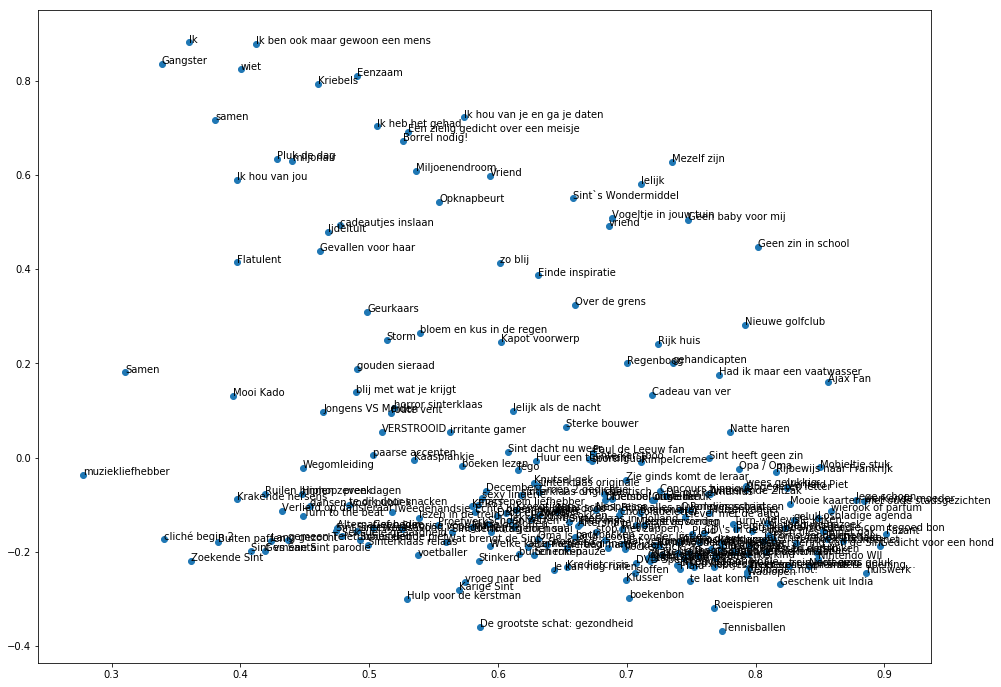

In [108]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,12))
plt.scatter(df_topicized['component_1'],df_topicized['component_2'])

for i, txt in enumerate(df_topicized['title']):
    plt.annotate(txt, (df_topicized['component_1'].iloc[i],df_topicized['component_2'].iloc[i]))

plt.show()

## Tag based LSA model, first two SVD components

In [109]:
df_tags_topicized = pd.DataFrame({ 
        'verse_id': df_verses_tagged['verse_id'].tolist(), 
        'title':df_verses_tagged['title'].tolist(),     
        'tags':df_verses_tagged['tags'].tolist(), 
        'component_1': tags_tm_lsa.T[0], 
        'component_2': tags_tm_lsa.T[1]}, index=df_verses_tagged['verse_id'])

In [110]:
df_tags_topicized.head(3)

,component_1,component_2,tags,title,verse_id
verse_id,,,,,
001,0.050817,0.035476,"gewicht,snacken,lekker,eten,bikini,zomer,dik,z...",te dik door snacken,001
002,0.335867,0.193532,"Cadeau,prachtig,Kado,mooi,machtig",Mooi Kado,002
011,0.317624,0.036049,"afbeelding,laat,hebbeding,internet,snel,cadeau...",Internet-cadeau te laat,011


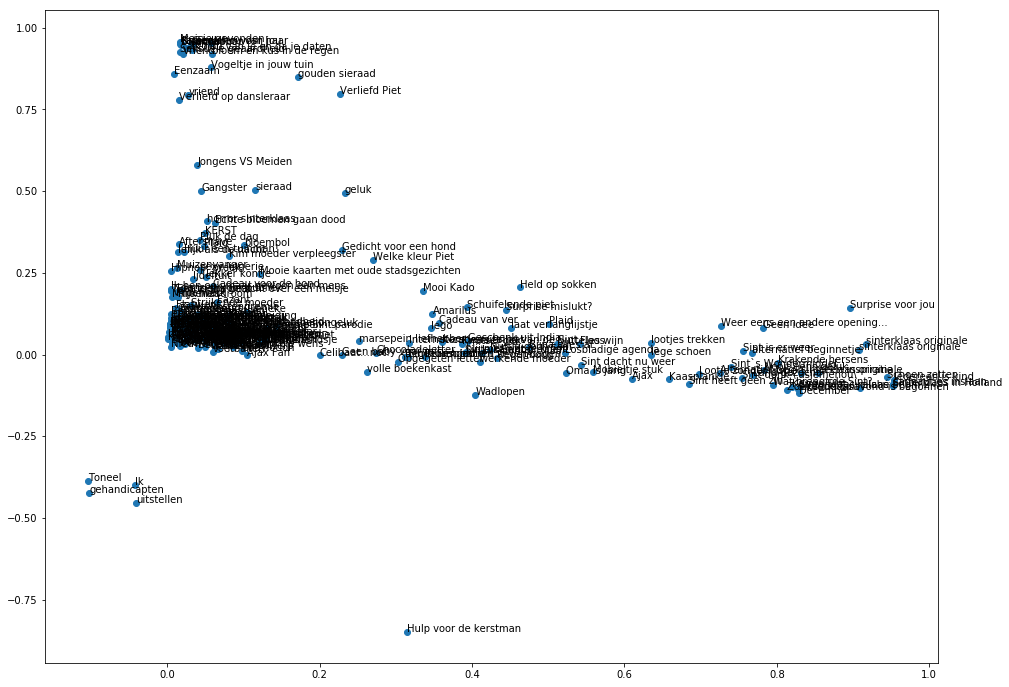

In [111]:
plt.figure(figsize=(16,12))
plt.scatter(df_tags_topicized['component_1'],df_tags_topicized['component_2'])

for i, txt in enumerate(df_tags_topicized['title']):
    plt.annotate(txt, (df_tags_topicized['component_1'].iloc[i],df_tags_topicized['component_2'].iloc[i]))

plt.show()

### Also make plots for some manual topic selections (tag based)

In [112]:
df_categorized[df_topicized['tags'].str.contains('sport')]

,tags,tags_c1,tags_c2,title,verse,verse_c1,verse_c2,verse_id
verse_id,,,,,,,,
05,"slank,dun,strak,sport,bewegen,sportief,lijf,bu...",0.045784,0.115351,sportfiguur,Heel actief ben jij sinds kort bezeten van een...,0.672664,-0.008103,05
11,"club,sport,vrouw,voetbal,zondag",0.059283,0.007574,voetballer,Als voetballers nog niet bestonden had jij ze ...,0.537933,-0.207897,11
31,"drop,zweet,sport,snoep",0.040553,0.021037,Drop en zweet,Drop is vooral meer zout dan zoet en zout is e...,0.599366,-0.124615,31
712,"roei,sterk,gast,gewichtsheffen,ambitie,gewicht...",0.017642,0.032673,Roeispieren,"De Sint dacht dat jij helemaal ontspoorde, toe...",0.768113,-0.318577,712
771,"verliezen,ballen,sport,bal,winnen,tennisbal,we...",0.095881,0.069800,Tennisballen,"Ook al is tennis jouw favoriete sport, op de b...",0.773939,-0.368358,771
951,"ajax,johan cruijf,politiek,az,fan,voetballen,v...",0.103961,-0.002883,Ajax Fan,"In ..... vinden we een pure Ajax fan, de liefd...",0.856053,0.160438,951


In [147]:
# Functions to make selections for specific tags

def get_booldf_filter(df_withtags, tag1, tag2):
    return (df_withtags['tags'].str.contains(tag1)) | (df_withtags['tags'].str.contains(tag2))

def get_selection(df_withtags, tag1, tag2):
    return df_withtags[get_booldf_filter(df_withtags, tag1,tag2)]

def plot_selection(tag1, tag2):
    df = get_selection(df_categorized, tag1,tag2)
    
    f, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
    ax1.scatter(df['verse_c1'],df['verse_c2'])
    ax1.set_title('Verses - LSA first 2 components')
    ax2.scatter(df['tags_c1'],df['tags_c2'])
    ax2.set_title('Tags - LSA first 2 components')

    for i, txt in enumerate(df['title']):
        ax1.annotate(txt, (df['verse_c1'].iloc[i],df['verse_c2'].iloc[i]))
        ax2.annotate(txt, (df['tags_c1'].iloc[i],df['tags_c2'].iloc[i]))
        
    plt.show()

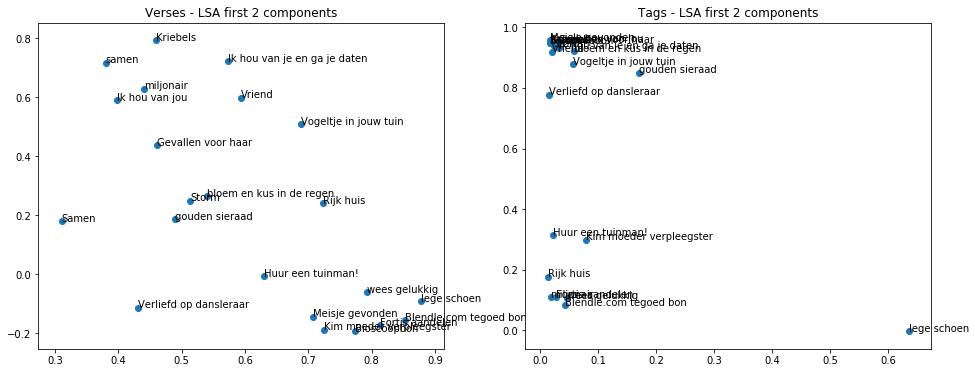

In [148]:
plot_selection('liefde','geld')

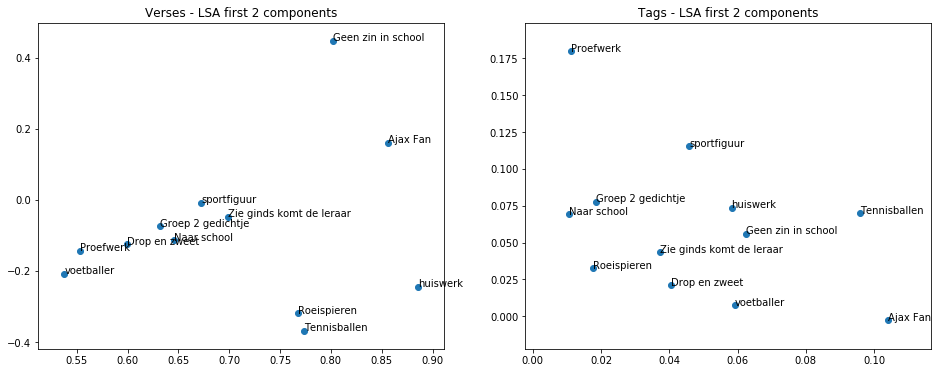

In [149]:
plot_selection('sport','school')

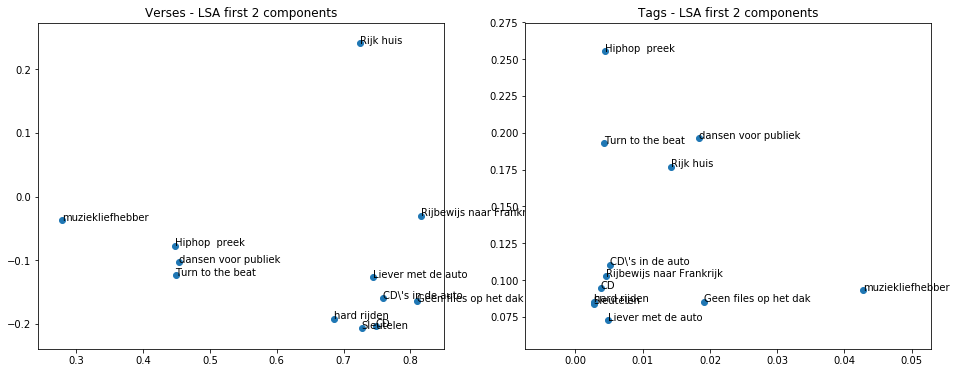

In [150]:
plot_selection('auto','muziek')

### None of the above graphs shows a clear positioning of topics

<hr>

# 8. Histograms of LSA Cosine Distance for selected verses

### Calculate similarities

In [117]:
# Compute document similarity using LSA components
sim_verse = np.asarray(np.asmatrix(dtm_lsa) * np.asmatrix(dtm_lsa).T)
sim_tags = np.asarray(np.asmatrix(tags_tm_lsa) * np.asmatrix(tags_tm_lsa).T)

df_sim_verse = pd.DataFrame(sim_verse,index=df_categorized['verse_id'], columns=df_categorized['verse_id'])
df_sim_tags = pd.DataFrame(sim_tags,index=df_categorized['verse_id'], columns=df_categorized['verse_id'])

### Now for specific categories by tag

In [118]:
df_filter = (df_categorized['tags'].str.contains('sport')) | (df_categorized['tags'].str.contains('muziek'))
df_sim_verse_sportmuziek = df_sim_verse[df_filter][df_sim_verse[df_filter].index.tolist()]

In [119]:
# extend with titles
df_sim_verse_sportmuziek = df_sim_verse_sportmuziek.join(df_categorized['title'])

In [120]:
titles = df_sim_verse_sportmuziek['title'].tolist() + ['title']
df_sim_verse_sportmuziek.columns = titles

In [121]:
df_sim_verse_sportmuziek

,sportfiguur,voetballer,CD,Drop en zweet,dansen voor publiek,muziekliefhebber,CD\'s in de auto,Turn to the beat,Hiphop preek,Roeispieren,Tennisballen,Ajax Fan,title
verse_id,,,,,,,,,,,,,
05,1.000000,0.427197,0.314691,0.583374,0.242682,0.747366,0.382503,0.109637,0.269043,0.668077,0.687840,0.350415,sportfiguur
11,0.427197,1.000000,0.456509,0.339880,0.474426,0.296967,0.511352,0.549748,0.274257,0.828991,0.537648,0.452743,voetballer
302,0.314691,0.456509,1.000000,0.250219,0.638743,0.171147,0.812681,0.738704,0.484870,0.520403,0.576883,0.792992,CD
31,0.583374,0.339880,0.250219,1.000000,0.139861,0.221993,0.560642,0.063683,0.226501,0.549523,0.506337,0.451866,Drop en zweet
321,0.242682,0.474426,0.638743,0.139861,1.000000,0.385237,0.431361,0.930208,0.878925,0.419441,0.069896,0.316301,dansen voor publiek
332,0.747366,0.296967,0.171147,0.221993,0.385237,1.000000,-0.040483,0.203913,0.306491,0.291794,0.276885,0.035145,muziekliefhebber
41,0.382503,0.511352,0.812681,0.560642,0.431361,-0.040483,1.000000,0.561767,0.336190,0.701686,0.678852,0.763012,CD\'s in de auto
421,0.109637,0.549748,0.738704,0.063683,0.930208,0.203913,0.561767,1.000000,0.678684,0.440403,0.155029,0.397801,Turn to the beat
521,0.269043,0.274257,0.484870,0.226501,0.878925,0.306491,0.336190,0.678684,1.000000,0.355054,-0.009699,0.276184,Hiphop preek


In [122]:
df_filter = (df_categorized['tags'].str.contains('liefde'))
df_sim_verse_liefde = df_sim_verse[df_filter][df_sim_verse[df_filter].index.tolist()]
df_sim_verse_liefde = df_sim_verse_liefde.join(df_categorized['title'])
df_sim_verse_liefde

,021,08,121,361,432,51,512,61,611,68,741,811,841,911,title
verse_id,,,,,,,,,,,,,,,
021,1.000000,0.435439,0.605372,0.593659,0.580497,0.591966,0.625731,0.083305,0.561943,0.720094,0.482389,0.047988,0.730481,0.803501,bloem en kus in de regen
08,0.435439,1.000000,0.465749,0.567070,0.616307,0.497851,0.316093,-0.058360,0.739686,0.169922,0.636057,0.652445,0.595063,0.321369,Gevallen voor haar
121,0.605372,0.465749,1.000000,0.826203,0.836401,0.388042,0.328077,0.360218,0.709679,0.627840,0.811014,0.078087,0.530848,0.822597,Ik hou van je en ga je daten
361,0.593659,0.567070,0.826203,1.000000,0.860581,0.753982,0.046898,0.096869,0.520365,0.470342,0.674426,0.196017,0.807737,0.686504,samen
432,0.580497,0.616307,0.836401,0.860581,1.000000,0.567944,0.170098,0.328505,0.615880,0.509991,0.838704,0.302789,0.709456,0.653837,Vriend
51,0.591966,0.497851,0.388042,0.753982,0.567944,1.000000,0.117689,0.002052,0.159030,0.398602,0.211353,0.450855,0.948568,0.360924,Samen
512,0.625731,0.316093,0.328077,0.046898,0.170098,0.117689,1.000000,0.391168,0.584575,0.522248,0.174988,0.241956,0.299385,0.417278,Bioscoopbon
61,0.083305,-0.058360,0.360218,0.096869,0.328505,0.002052,0.391168,1.000000,0.244800,0.084952,0.188879,0.068506,0.063494,-0.021032,Meisje gevonden
611,0.561943,0.739686,0.709679,0.520365,0.615880,0.159030,0.584575,0.244800,1.000000,0.325157,0.725089,0.203685,0.371610,0.583810,Vogeltje in jouw tuin


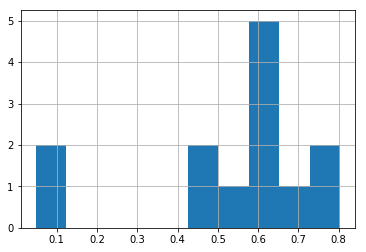

In [123]:
avg_021_liefde = df_sim_verse_liefde[(df_sim_verse_liefde.index!='021')]['021']
avg_021_liefde.hist()

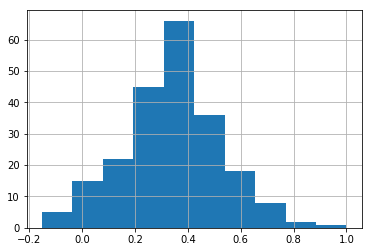

In [124]:
avg_021_all = df_sim_verse[(~df_sim_verse.index.isin(avg_021_liefde.index))]['021']
avg_021_all.hist()

In [125]:
df_filter = (df_categorized['tags'].str.contains('auto'))
df_sim_verse_auto = df_sim_verse[df_filter][df_sim_verse[df_filter].index.tolist()]
df_sim_verse_auto = df_sim_verse_auto.join(df_categorized['title'])
df_sim_verse_auto

,042,09,41,55,65,73,85,title
verse_id,,,,,,,,
042,1.000000,0.641610,0.776662,0.671840,0.699975,0.641302,0.624542,Rijbewijs naar Frankrijk
09,0.641610,1.000000,0.593061,0.633312,0.462711,0.565339,0.513814,Sleutelen
41,0.776662,0.593061,1.000000,0.911696,0.681258,0.428602,0.807446,CD\'s in de auto
55,0.671840,0.633312,0.911696,1.000000,0.809385,0.525897,0.740782,Geen files op het dak
65,0.699975,0.462711,0.681258,0.809385,1.000000,0.479837,0.487025,Rijk huis
73,0.641302,0.565339,0.428602,0.525897,0.479837,1.000000,0.666186,hard rijden
85,0.624542,0.513814,0.807446,0.740782,0.487025,0.666186,1.000000,Liever met de auto


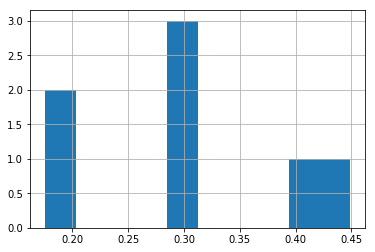

In [126]:
avg_021_auto = df_sim_verse[(df_sim_verse.index.isin(df_sim_verse_auto.index))]['021']
avg_021_auto.hist()

In [127]:
df_sim_verse['081'].sort_values(ascending=False).head(10).tolist()

[1.0000000000000002,
 0.9564878254400638,
 0.919527057431087,
 0.8565507326246331,
 0.8467242108435182,
 0.8446128837461985,
 0.8277077168178524,
 0.8254271483672287,
 0.8227333724580687,
 0.8218244382760341]

<hr>

# 9. Compare LSA Cosine Distances to tag-based caterogization

In [128]:
# Helper functions

def show_title_and_score(verse_id, score):
    title = df_categorized.loc[[verse_id]][['title']].iloc[0][0]
    print(title, "({:.2f})".format(score))
    #print(title, "\t ","{:.2f}".format(score))

def show_closest(verse_id, maxnum, min_score=0.5, elaborate = False):    
    col1 = df_sim_verse[verse_id].sort_values(ascending=False).head(maxnum)
    col1 = col1[col1>min_score]
    ids1 = col1.index.tolist()
    scores1 = col1.tolist()
    col2 = df_sim_tags[verse_id].sort_values(ascending=False).head(maxnum)
    col2 = col2[col2>min_score]
    ids2 = col2.index.tolist()
    scores2 = col2.tolist()
    if (elaborate):
        show_verse(ids1[0])
        print("---------------")
        print("\n- LSA ON VERSES -")
        for i in range(0,len(ids1)): show_verse(ids1[i], sameline=True)
        print("\n- LSA ON TAGS -")
        for i in range(0,len(ids2)): show_verse(ids2[i], sameline=True)
    else:
        show_title(ids1[0])
        print("---------------")
        print("\n- LSA ON VERSES -")
        for i in range(0,len(ids1)): show_title_and_score(ids1[i],scores1[i])
        print("\n- LSA ON TAGS -")
        for i in range(0,len(ids2)): show_title_and_score(ids2[i],scores2[i])
            

In [129]:
def show_by_tag(tag1, tag2=None):
    ids = df_categorized[df_categorized['tags'].str.contains(tag1)]['verse_id'].tolist()
    if (tag2!=None):
        ids2 = df_categorized[df_categorized['tags'].str.contains(tag2)]['verse_id'].tolist()
        for id2 in ids2: 
            if (id2 not in ids): ids.append(id2)
    print("\n- DIRECT TAG SEARCH -")
    for i in range(0,len(ids)): show_title(ids[i])

** Topic verses: **
    
Love -> '811' <br/>
Money -> '24' <br/>
Sports -> '05' <br/>
School -> '081' <br/>
Cars -> '73' <br/>
Music -> '332' <br/>
Computers -> '112' <br/>

### Topic 'Love'

In [130]:
show_closest('811', 10) # ABOUT LOVE
show_by_tag('liefde')

Verliefd op dansleraar
---------------

- LSA ON VERSES -
Verliefd op dansleraar (1.00)
te dik door snacken (0.94)
Hiphop  preek (0.90)
Seksuele geaardheid (0.89)
dansen voor publiek (0.88)
Turn to the beat (0.82)
Jongens VS Meiden (0.81)
Welke kleur Piet (0.78)
Schuifelende piet (0.76)
Surprise mislukt? (0.73)

- LSA ON TAGS -
Verliefd op dansleraar (1.00)
Seksuele geaardheid (0.86)
Kriebels (0.79)
Samen (0.77)
Meisje gevonden (0.77)
Hiphop  preek (0.77)
bloem en kus in de regen (0.73)
dansen voor publiek (0.73)
Bioscoopbon (0.72)
Turn to the beat (0.72)

- DIRECT TAG SEARCH -
bloem en kus in de regen
Gevallen voor haar
Ik hou van je en ga je daten
samen
Vriend
Samen
Bioscoopbon
Meisje gevonden
Vogeltje in jouw tuin
gouden sieraad
Kriebels
Verliefd op dansleraar
Storm
Ik hou van jou


### Topic 'Money'

In [131]:
show_closest('24', 10) # ABOUT LOVE
show_by_tag('geld')

Kredietcrisis
---------------

- LSA ON VERSES -
Kredietcrisis (1.00)
Kroegtijger (0.96)
Boerenlater (0.87)
bloembol (0.85)
te laat komen (0.83)
Turn-wijf (0.83)
Cd kopieren (0.81)
Echte bloemen gaan dood (0.80)
Knutsel-gek (0.80)
Natte haren (0.79)

- LSA ON TAGS -
Kredietcrisis (1.00)
De grootste schat: gezondheid (0.98)
Fortis aandelen (0.98)
miljonair (0.97)
Ik ben ook maar gewoon een mens (0.97)
Nespresso (0.97)
Miljoenendroom (0.97)
buiten roken (0.96)
Rijk huis (0.93)
Huur een tuinman! (0.93)

- DIRECT TAG SEARCH -
wees gelukkig
Blendle.com tegoed bon
Fortis aandelen
lege schoen
miljonair
Rijk huis
Kim moeder verpleegster
Huur een tuinman!


### Topic 'Sports'

In [132]:
show_closest('05',10)
show_by_tag('sport')

sportfiguur
---------------

- LSA ON VERSES -
sportfiguur (1.00)
bloembol (0.93)
Natte haren (0.86)
Glaasje wijn (0.83)
zwanger (0.82)
Overlevingsstrijd (0.80)
Boerenlater (0.80)
Toneel (0.80)
boekenbon (0.79)
Kredietcrisis (0.77)

- LSA ON TAGS -
sportfiguur (1.00)
(Spijker)broek (0.86)
sexy lingerie (0.83)
lekker kontje (0.82)
Drop en zweet (0.80)
Opa / Oma (0.80)
te dik door snacken (0.79)
Stinkerd (0.78)
Geurkaars (0.78)
Chocoladeletter (0.78)

- DIRECT TAG SEARCH -
sportfiguur
voetballer
Drop en zweet
Roeispieren
Tennisballen
Ajax Fan


### Topic 'School'

In [133]:
show_closest('081',10)
show_by_tag('school')

Proefwerk
---------------

- LSA ON VERSES -
Proefwerk (1.00)
Meisje gevonden (0.96)
Groep 2 gedichtje (0.92)
geen enkele wens (0.86)
bodylotion (0.85)
Verhuizen (0.84)
VERSTROOID (0.83)
Golfhandschoen (0.83)
Naar school (0.82)
wierook of parfum (0.82)

- LSA ON TAGS -
Proefwerk (1.00)
Naar school (0.98)
huiswerk (0.95)
Groep 2 gedichtje (0.94)
Geen zin in school (0.91)
Zie ginds komt de leraar (0.90)
boekenbon (0.86)
boek halen bij de bib. (0.85)
boeken lezen (0.85)
Blendle.com tegoed bon (0.84)

- DIRECT TAG SEARCH -
Proefwerk
Naar school
Geen zin in school
Groep 2 gedichtje
huiswerk
Zie ginds komt de leraar


### Topic 'Cars'

In [134]:
show_closest('73', 10)
show_by_tag('auto')

hard rijden
---------------

- LSA ON VERSES -
hard rijden (1.00)
Cd kopieren (0.95)
Ouwe meuk (0.87)
boek halen bij de bib. (0.85)
Fazant (0.85)
Muizenvanger (0.83)
Cadeau voor de hond (0.83)
treinvertaging (0.81)
Mooie kaarten met oude stadsgezichten (0.81)
Knutsel-gek (0.81)

- LSA ON TAGS -
hard rijden (1.00)
Sleutelen (1.00)
Klusser (1.00)
Geen files op het dak (0.98)
Liever met de auto (0.92)
Sterke bouwer (0.90)
Rijbewijs naar Frankrijk (0.88)
Rijk huis (0.88)
Fortis aandelen (0.80)
CD\'s in de auto (0.80)

- DIRECT TAG SEARCH -
Rijbewijs naar Frankrijk
Sleutelen
CD\'s in de auto
Geen files op het dak
Rijk huis
hard rijden
Liever met de auto


### Topic 'Music'

In [135]:
show_closest('332',10)
show_by_tag('muziek')

muziekliefhebber
---------------

- LSA ON VERSES -
muziekliefhebber (1.00)
Fles wijn (0.78)
zwanger (0.76)
sportfiguur (0.75)
Kaasplankje (0.74)
gouden sieraad (0.73)
Echte bloemen gaan dood (0.73)
December (0.71)
volle boekenkast (0.71)
Boerenlater (0.69)

- LSA ON TAGS -
muziekliefhebber (1.00)
dansen voor publiek (0.99)
Turn to the beat (0.99)
CD (0.98)
Hiphop  preek (0.98)
CD\'s in de auto (0.90)
Rondjes schaatsen (0.84)
Pluk de dag (0.76)
foute vent (0.67)
Verliefd op dansleraar (0.64)

- DIRECT TAG SEARCH -
CD
dansen voor publiek
muziekliefhebber
CD\'s in de auto
Turn to the beat
Hiphop  preek


### Topic 'Computer'

In [136]:
show_closest('112',10)
show_by_tag('computer', 'scherm')

irritante gamer
---------------

- LSA ON VERSES -
irritante gamer (1.00)
lelijk als de nacht (0.91)
Twitterende Zitzak (0.88)
televisie kijken (0.88)
Aftershave (0.82)
backpacken (0.79)
reisboek via internet (0.79)
Geen files op het dak (0.77)
Rijk huis (0.77)
CD\'s in de auto (0.76)

- LSA ON TAGS -
irritante gamer (1.00)
Nintendo WII (0.93)
Sterke drank (0.89)
Borrel nodig! (0.89)
Glaasje wijn (0.84)
Fles wijn (0.83)
televisie kijken (0.81)
Ik heb het gehad (0.80)
Scherm-pauze (0.80)
backpacken (0.78)

- DIRECT TAG SEARCH -
irritante gamer
Nintendo WII
Blendle.com tegoed bon
Scherm-pauze
Twitterende Zitzak


<hr>

# 10 Conclusions

### The traditional tag-based search outperforms the LSA models on this small corpus


Michael Janus, 14 October 2018